In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
import gc
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
gc.collect()

0

In [ ]:
df_train_vrd_rel = pd.read_hdf('vrd/temp/df_train_vrd_rel.h5', 'df_train_vrd_rel')
df_valid_vrd_rel = pd.read_hdf('vrd/temp/df_valid_vrd_rel.h5', 'df_valid_vrd_rel')
df_test_rel = pd.read_hdf('vrd/temp/df_test_rel.h5', 'df_test_rel')

## 1. Train Relationship Model

### 1.1 Prepare Features

In [4]:
def computeAspectRatio1(row):
    return (row["XMax1"]-row["XMin1"])/(row["YMax1"]-row["YMin1"])

def computeAspectRatio2(row):
    return (row["XMax2"]-row["XMin2"])/(row["YMax2"]-row["YMin2"])

def computeSize1(row):
    return (row["XMax1"]-row["XMin1"])*(row["YMax1"]-row["YMin1"])

def computeSize2(row):
    return (row["XMax2"]-row["XMin2"])*(row["YMax2"]-row["YMin2"])

def computeSizeDiff(row):
    return computeSize1(row)/computeSize2(row)

def computeCenterX1(row):
    return (row["XMax1"]-row["XMin1"])/2+row["XMin1"]

def computeCenterX2(row):
    return (row["XMax2"]-row["XMin2"])/2+row["XMin2"]

def computeCenterY1(row):
    return (row["YMax1"]-row["YMin1"])/2+row["YMin1"]

def computeCenterY2(row):
    return (row["YMax2"]-row["YMin2"])/2+row["YMin2"]

def computeCenterXDiff(row):
    return (computeCenterX1(row)-computeCenterX2(row)) / (row["XMax1"]-row["XMin1"])
    
def computeCenterYDiff(row):
    return (computeCenterY1(row)-computeCenterY2(row)) / (row["YMax1"]-row["YMin1"])

def computeIOU(row):
    xA = max(row["XMin1"], row["XMin2"])
    yA = max(row["YMin1"], row["YMin2"])
    xB = min(row["XMax1"], row["XMax2"])
    yB = min(row["YMax1"], row["YMax2"])

    interArea = max(0, xB - xA) * max(0, yB - yA)

    boxAArea = (row["XMax1"] - row["XMin1"]) * (row["YMax1"] - row["YMin1"])
    boxBArea = (row["XMax2"] - row["XMin2"]) * (row["YMax2"] - row["YMin2"])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def computeIntersection1(row):
    xA = max(row["XMin1"], row["XMin2"])
    yA = max(row["YMin1"], row["YMin2"])
    xB = min(row["XMax1"], row["XMax2"])
    yB = min(row["YMax1"], row["YMax2"])

    interArea = max(0, xB - xA) * max(0, yB - yA)

    return interArea / computeSize1(row)

def computeIntersection2(row):
    xA = max(row["XMin1"], row["XMin2"])
    yA = max(row["YMin1"], row["YMin2"])
    xB = min(row["XMax1"], row["XMax2"])
    yB = min(row["YMax1"], row["YMax2"])

    interArea = max(0, xB - xA) * max(0, yB - yA)

    return interArea / computeSize2(row)

def add_features(df):
    df["AspectRatio1"] = df.progress_apply(lambda row: computeAspectRatio1(row), axis=1)
    df["AspectRatio2"] = df.progress_apply(lambda row: computeAspectRatio2(row), axis=1)

#     df["Size1"] = df.progress_apply(lambda row: computeSize1(row), axis=1)
#     df["Size2"] = df.progress_apply(lambda row: computeSize2(row), axis=1)
    
    df["sizeDiff"] = df.progress_apply(lambda row: computeSizeDiff(row), axis=1)

#     df["CenterX1"] = df.progress_apply(lambda row: computeCenterX1(row), axis=1)
#     df["CenterX2"] = df.progress_apply(lambda row: computeCenterX2(row), axis=1)
#     df["CenterY1"] = df.progress_apply(lambda row: computeCenterY1(row), axis=1)
#     df["CenterY2"] = df.progress_apply(lambda row: computeCenterY2(row), axis=1)

    df["XCenterDiff"] = df.progress_apply(lambda row: computeCenterXDiff(row), axis=1)
    df["YCenterDiff"] = df.progress_apply(lambda row: computeCenterYDiff(row), axis=1)

#     df["CenterDiff"] = df.progress_apply(lambda row: computeCenterDiff(row), axis=1)
#     df["CenterX"] = df.progress_apply(lambda row: computeCenterX(row), axis=1)
#     df["CenterY"] = df.progress_apply(lambda row: computeCenterY(row), axis=1)

    df["IOU"] = df.progress_apply(lambda row: computeIOU(row), axis=1)
    
    df["InterArea1"] = df.progress_apply(lambda row: computeIntersection1(row), axis=1)
    df["InterArea2"] = df.progress_apply(lambda row: computeIntersection2(row), axis=1)

In [7]:
add_features(df_train_vrd_rel)

100%|██████████| 180626/180626 [00:30<00:00, 5851.47it/s]


In [5]:
add_features(df_valid_vrd_rel)

100%|██████████| 1418/1418 [00:00<00:00, 4147.85it/s]


In [9]:
add_features(df_test_rel)

100%|██████████| 3601704/3601704 [10:47<00:00, 5559.99it/s]


In [10]:
df_train_vrd_rel.to_hdf('vrd/df_train_vrd_rel_features2.h5', key='df_train_vrd_rel', mode='w', format='t')
df_valid_vrd_rel.to_hdf('vrd/df_valid_vrd_rel_features2.h5', key='df_valid_vrd_rel', mode='w', format='t')
df_test_rel.to_hdf('vrd/df_test_rel_features2.h5', key='df_test_rel', mode='w', format='t')

### 1.2 Load Features

In [3]:
df_train_vrd_rel = pd.read_hdf('vrd/df_train_vrd_rel_features2.h5', 'df_train_vrd_rel')
df_valid_vrd_rel = pd.read_hdf('vrd/df_valid_vrd_rel_features2.h5', 'df_valid_vrd_rel')
df_test_rel = pd.read_hdf('vrd/df_test_rel_features2.h5', 'df_test_rel') 

In [4]:
drop_cols = ["XMin1", "XMax1", "YMin1", "YMax1", "XMin2", "XMax2", "YMin2", "YMax2"]
X_train = df_train_vrd_rel.drop(drop_cols+['ImageID','RelationshipLabel'], axis=1)
y_train = df_train_vrd_rel['RelationshipLabel'].cat.codes 
X_valid = df_valid_vrd_rel.drop(drop_cols+['ImageID','RelationshipLabel'], axis=1)
y_valid = df_valid_vrd_rel['RelationshipLabel'].cat.codes # pd.get_dummies(df_valid_vrd_rel['RelationshipLabel']).values

In [5]:
X_test = df_test_rel.drop(drop_cols+['ImageID','Confidence1','Confidence2','RelationshipLabel'], axis=1)

In [6]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid)

In [39]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'multiclass',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.07,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 1.2,
          'reg_lambda': 1.2,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 9,
          'metric' : 'multi_logloss'
          }

In [40]:
gridParams = {
    'learning_rate': [0.01, 0.05, 0.07],
    'n_estimators': [8,16],
    'num_leaves': [20, 24, 27, 42, 60,64],
    'boosting_type' : ['gbdt'],
    'objective' : ['multi_logloss'],
    'random_state' : [501], 
    'colsample_bytree' : [0.64, 0.65],
    'subsample' : [0.7,0.75],
    #'reg_alpha' : [1, 1.2],
    #'reg_lambda' : [ 1.2, 1.4],
    }

In [41]:
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'multi_logloss',
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

In [42]:
mdl.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq', 'max_bin', 'scale_pos_weight'])

In [43]:
grid = GridSearchCV(mdl, gridParams, verbose=2, cv=4, n_jobs=-1)

In [ ]:
grid.fit(X_train, y_train)

Fitting 4 folds for each of 144 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   24.4s


In [ ]:
print(grid.best_params_)
print(grid.best_score_)

In [ ]:
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
# params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
#params['reg_alpha'] = grid.best_params_['reg_alpha']
#params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']

In [ ]:
# params = {
#         'objective': 'multiclass',
#         'boosting': 'gbdt',
#         'learning_rate': 0.01 ,
#         'verbose': 0,
#         'num_leaves': 64,
#         'bagging_fraction': 0.95,
#         'bagging_freq': 1,
#         'bagging_seed': 1,
#         'feature_fraction': 0.9,
#         'feature_fraction_seed': 1,
#         'max_bin': 512,
#         'num_rounds': 10000,
#         'metric': ['multi_logloss'],
#         'num_class': 9
#     }
cats_dict = dict( zip( df_valid_vrd_rel['RelationshipLabel'].cat.codes, df_valid_vrd_rel['RelationshipLabel'] ) )

In [ ]:
lgbm_model = lgb.train(params, train_set = lgb_train, num_boost_round=1000, valid_sets = lgb_valid, verbose_eval=5, early_stopping_rounds=40)

In [28]:
lgbm_model = lgb.train(params, train_set = lgb_train, num_boost_round=1000, valid_sets = lgb_valid, verbose_eval=5, early_stopping_rounds=40)

Training until validation scores don't improve for 40 rounds.
[5]	valid_0's multi_logloss: 1.07362
[10]	valid_0's multi_logloss: 0.860642
[15]	valid_0's multi_logloss: 0.708895
[20]	valid_0's multi_logloss: 0.595456
[25]	valid_0's multi_logloss: 0.525077
[30]	valid_0's multi_logloss: 0.46848
[35]	valid_0's multi_logloss: 0.433397
[40]	valid_0's multi_logloss: 0.407806
[45]	valid_0's multi_logloss: 0.390123
[50]	valid_0's multi_logloss: 0.367451
[55]	valid_0's multi_logloss: 0.348929
[60]	valid_0's multi_logloss: 0.335692
[65]	valid_0's multi_logloss: 0.326214
[70]	valid_0's multi_logloss: 0.317889
[75]	valid_0's multi_logloss: 0.310315
[80]	valid_0's multi_logloss: 0.305279
[85]	valid_0's multi_logloss: 0.301292
[90]	valid_0's multi_logloss: 0.297597
[95]	valid_0's multi_logloss: 0.293887
[100]	valid_0's multi_logloss: 0.291454
[105]	valid_0's multi_logloss: 0.289566
[110]	valid_0's multi_logloss: 0.28758
[115]	valid_0's multi_logloss: 0.286361
[120]	valid_0's multi_logloss: 0.284916
[

In [35]:
lgbm_model.save_model('model3.txt')

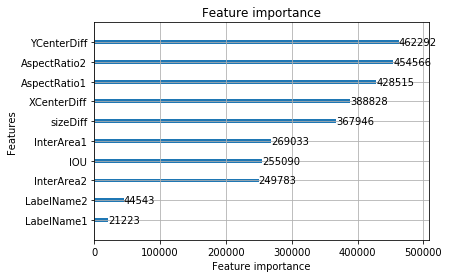

In [37]:
lgb.plot_importance(lgbm_model)

### 1.3 Evaluate

In [31]:
lgbm_model = lgb.Booster(model_file='model2.txt')  # init model

In [35]:
batch_size = 5000
len(X_test)

3601704

In [36]:
for i in tqdm(range(0,len(X_test),batch_size)):
    total_batch_size = min(i+batch_size, len(X_test))
    predictions = lgbm_model.predict(X_test[i:total_batch_size], num_iteration=lgbm_model.best_iteration)
    predict_rel_label = predictions.argmax(axis=1)
    cat_pred_rel_label = [cats_dict[x] for x in predict_rel_label]
    df_test_rel[i:total_batch_size]["RelationshipLabel"] = cat_pred_rel_label


  0%|          | 0/721 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  

  1%|          | 7/721 [00:57<1:37:45,  8.21s/it]

KeyboardInterrupt: 

### 1.4 THIS IS WHAT WE WANT WHEN WE COMBINE

In [ ]:
df_test_rel.to_csv("submission_rel2.csv",index=False)

### 1.5 Individual Submission

In [14]:
list_imgids = list(df_test_rel['ImageID'].unique())

In [15]:
df_group = df_test_rel.groupby('ImageID')

In [ ]:
final_sub = []
i=0
for image_id in tqdm(list_imgids):
    gp = df_test_rel[df_test_rel['ImageID']==image_id]
    predStr = ""
    for index, row in gp.iterrows():
        confidence = (row["Confidence1"] + row["Confidence2"])/2
        label1 = row["LabelName1"]
        XMin1, YMin1, XMax1, YMax1 = row["XMin1"], row["YMin1"], row["XMax1"], row["YMax1"] 
        label2 = row["LabelName2"]
        XMin2, YMin2, XMax2, YMax2 = row["XMin2"], row["YMin2"], row["XMax2"], row["YMax2"] 
        relLabel = row["RelationshipLabel"]
        predStr += str(confidence) + " " + str(label1) + " " + \
          str(XMin1) + " "+ str(YMin1) + " " + str(XMax1) + " "+ str(YMax1) + " " + \
          str(label2) + " " + \
          str(XMin2) + " "+ str(YMin2) + " " + str(XMax2) + " "+ str(YMax2) + " " + \
          str(relLabel) + " "
    dict_res = {
      "ImageId": image_id,
      "PredictionString": predStr,
    }
    final_sub.append(dict_res)
    i+=1

 90%|█████████ | 43184/47727 [3:35:23<23:12,  3.26it/s]  

In [ ]:
len(final_sub)

In [ ]:
df_bbox_submission = pd.read_csv("submission.csv")
list_test_imageIds = df_bbox_submission["ImageID"].values

In [ ]:
df_submit = pd.DataFrame(final_sub)

In [ ]:
list_predicted_imgs = df_submit.ImageId.values
main_list = list(set(list_test_imageIds) - set(list_predicted_imgs))
len(main_list)

In [ ]:
append_unpredicted = []
for ml in main_list:
    append_unpredicted.append({
      "ImageId":ml,
      "PredictionString":""
    })
df_append = pd.DataFrame(append_unpredicted)

In [ ]:
df_final = pd.concat([df_submit, df_append], ignore_index=True, sort =False)

In [ ]:
df_final.head()

In [ ]:
df_final.to_csv("vrd_submission.csv", index=False)